# Capstone Project

## Park Slope Parents Membership

For this portion of the project I'm going to be making a classification model to determine whether someone is likely to be a long term or short term member.

The first step is figuring out where that line is. 

Median membership is 2 years, which is also close to the threshold I saw was when many folks check out relative to their child's birth (22 months). This seems like the ideal choice.

I'll also be doing a cluster analysis, because I love those.

In [1]:
# Load libraries

-

In [2]:
# read in data

dfn = pd.read_csv("../../projects/psp/raw_data/PSP_data_4capstone.csv")
dfn.info()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14914 entries, 0 to 14913
Data columns (total 23 columns):
mem_no                14914 non-null object
address               14914 non-null object
city                  14914 non-null object
state                 14914 non-null object
zip                   14914 non-null int64
joined                14914 non-null object
exp_date              14914 non-null object
status                14914 non-null object
mem_type              14914 non-null object
last_renewal_date     14914 non-null object
gender                14914 non-null object
club_email            14914 non-null object
dup                   14914 non-null object
parent_status         14914 non-null object
kid_count             14914 non-null float64
kid1_bday             14914 non-null object
kid2_bday             14914 non-null object
join_reason           10144 non-null object
advice_grp            14914 non-null int64
classifieds           14914 non-null int64
classifieds_s

,mem_no,address,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,...,parent_status,kid_count,kid1_bday,kid2_bday,join_reason,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,438_12th_street,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,...,Yes,2.0,4/14/85,4/14/85,dfs,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,580_5th_street,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,...,Yes,2.0,12/11/02,12/11/02,NaN,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,502_13th_st,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,...,Yes,2.0,1/1/01,1/1/01,no,1,1,0,No,Other
3,00118,1512_10th_ave,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,...,Yes,2.0,5/17/02,9/14/04,This is a renewal,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,434_13th_st,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,...,Yes,2.0,10/5/01,7/31/07,"Yes, I'm in love with you, Susan Fox! :-)",1,1,0,Yes,A PSP member who is a friend/neighbor


In [3]:
# # not all types carried over from when the data was saved (datetime in particular, which
# # pleases me not at all).

dfn.joined = pd.to_datetime(dfn.joined, format='%Y/%m/%d')
dfn.exp_date = pd.to_datetime(dfn.exp_date, format='%Y/%m/%d')
dfn.last_renewal_date = pd.to_datetime(dfn.last_renewal_date, format='%Y/%m/%d')
dfn.kid1_bday = pd.to_datetime(dfn.kid1_bday, format='%m/%d/%y')
dfn.kid2_bday = pd.to_datetime(dfn.kid2_bday, format='%m/%d/%y')

In [4]:
# getting rid of address and join reason

dfn.drop(["address",'join_reason','city','state'], axis=1, inplace=True)

dfn.head()



,mem_no,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,club_email,dup,parent_status,kid_count,kid1_bday,kid2_bday,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,Yes,NO,Yes,2.0,1985-04-14,1985-04-14,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,Yes,NO,Yes,2.0,2002-12-11,2002-12-11,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,Yes,YES,Yes,2.0,2001-01-01,2001-01-01,1,1,0,No,Other
3,00118,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,Yes,NO,Yes,2.0,2002-05-17,2004-09-14,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,Yes,YES,Yes,2.0,2001-10-05,2007-07-31,1,1,0,Yes,A PSP member who is a friend/neighbor


In [5]:
# columns for joined month and year

dfn['join_year'] = dfn['joined'].dt.year
dfn['join_month'] = dfn['joined'].dt.month

# columns for exp_date year

dfn['exp_year'] = dfn['exp_date'].dt.year

# # columns for 1st kid's birth month and year
dfn['k1bday_year'] = dfn['kid1_bday'].dt.year
dfn['k1bday_month'] = dfn['kid1_bday'].dt.month

# # columns for 2nd kid's birth month and year
dfn['k2bday_year'] = dfn['kid2_bday'].dt.year
dfn['k2bday_month'] = dfn['kid2_bday'].dt.month


dfn.head()

,mem_no,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,club_email,dup,...,classifieds_spouse,tony_kids,discovered,join_year,join_month,exp_year,k1bday_year,k1bday_month,k2bday_year,k2bday_month
0,00002,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,Yes,NO,...,1,Yes,A PSP member who is a friend/neighbor,2009,2,2020,1985,4,1985,4
1,00004,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,Yes,NO,...,0,Yes,A PSP member I don't know told me about it,2009,4,2020,2002,12,2002,12
2,00101,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,Yes,YES,...,0,No,Other,2002,7,2014,2001,1,2001,1
3,00118,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,Yes,NO,...,0,No,A PSP member who is a friend/neighbor,2002,8,2017,2002,5,2004,9
4,00121,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,Yes,YES,...,0,Yes,A PSP member who is a friend/neighbor,2002,8,2019,2001,10,2007,7


In [6]:
# check dates for out of consideration range. basically for grandparents who are using their children's birth dates,
# not their grandchildren's. Org started in 2002 so will assume anything prior to 1990 will be out of range

dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] < 2018])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] < 2018])

In [7]:
# adding column for membership duration
# in order to convert the timedelta result I divided by 6.048E+14 which gives me weeks as integers (just trust me)

dfn['mem_duration'] = ((dfn['exp_date'] - dfn['joined'])/604800000000000).astype(int)

In [8]:
# creating dummies for over/under 2 years

# md of 1 == n is a long term member

md = []

for n in dfn.mem_duration:
    if n >= 104:
        md.append(1)
    else:
        md.append(0)
        
md_s = pd.Series(md)
# mdsl = ['mem_no']
# mds = pd.DataFrame(dfn['mem_no'])
md_s.isnull().sum()


# mds.to_csv('../../projects/psp/dfmds.csv')

0

In [9]:
# concat long-short to dfn

dfn=dfn.set_index(md_s.index)
# dfn['long_short'] = md_s.iloc[:,0].values
dfn['long_short']=md_s

# dfn = pd.concat([dfn,md_s], axis=1)
# dfn.rename (columns={0:"long_short"}, inplace=True)
# dfn.drop([0], axis=0, inplace=True)
# print dfn.info()
# print " "
# print dfn.describe()
print dfn.isnull().sum()
dfn.head()


mem_no                0
zip                   0
joined                0
exp_date              0
status                0
mem_type              0
last_renewal_date     0
gender                0
club_email            0
dup                   0
parent_status         0
kid_count             0
kid1_bday             0
kid2_bday             0
advice_grp            0
classifieds           0
classifieds_spouse    0
tony_kids             0
discovered            2
join_year             0
join_month            0
exp_year              0
k1bday_year           0
k1bday_month          0
k2bday_year           0
k2bday_month          0
mem_duration          0
long_short            0
dtype: int64


,mem_no,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,club_email,dup,...,discovered,join_year,join_month,exp_year,k1bday_year,k1bday_month,k2bday_year,k2bday_month,mem_duration,long_short
0,00004,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,Yes,NO,...,A PSP member I don't know told me about it,2009,4,2020,2002,12,2002,12,573,1
1,00101,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,Yes,YES,...,Other,2002,7,2014,2001,1,2001,1,634,1
2,00118,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,Yes,NO,...,A PSP member who is a friend/neighbor,2002,8,2017,2002,5,2004,9,774,1
3,00121,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,Yes,YES,...,A PSP member who is a friend/neighbor,2002,8,2019,2001,10,2007,7,876,1
4,00122,11215,2002-08-28,2017-06-20,Active,1 year membership ($40),2002-08-28,Female,Yes,YES,...,A PSP member who is a friend/neighbor,2002,8,2017,2002,7,2002,7,772,1


In [10]:
# creating df for diff b/n birth and join

jvbcols = ['joined','kid1_bday']

jvb_df = pd.DataFrame(dfn[jvbcols])

jvb_df.head()


,joined,kid1_bday
0,2009-04-13,2002-12-11
1,2002-07-17,2001-01-01
2,2002-08-13,2002-05-17
3,2002-08-26,2001-10-05
4,2002-08-28,2002-07-18


In [11]:
# create column for jvb

jvb_df['jvb'] = (jvb_df['joined']-jvb_df['kid1_bday'])
print jvb_df.info()
jvb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 3 columns):
joined       14591 non-null datetime64[ns]
kid1_bday    14591 non-null datetime64[ns]
jvb          14591 non-null timedelta64[ns]
dtypes: datetime64[ns](2), timedelta64[ns](1)
memory usage: 342.0 KB
None


,joined,kid1_bday,jvb
0,2009-04-13,2002-12-11,2315 days
1,2002-07-17,2001-01-01,562 days
2,2002-08-13,2002-05-17,88 days
3,2002-08-26,2001-10-05,325 days
4,2002-08-28,2002-07-18,41 days


In [12]:
# drop base columns, leaving just the calculated one

jvb_df.drop(['joined','kid1_bday'], axis=1, inplace=True)
print jvb_df.info()
jvb_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 1 columns):
jvb    14591 non-null timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 114.1 KB
None


,jvb
0,2315 days
1,562 days
2,88 days
3,325 days
4,41 days


In [13]:
# change calc to int 

jvb_df['jvb2'] = jvb_df['jvb']/timedelta(1)

In [14]:
jvb_df.pop('jvb');

In [15]:
# get dummies for whether a child was born before or after membership

# if a family joined before their child was born x == 1

def positive(x):
    if x <= 0:
        return 0
    else:
        return 1
    
jvb_df['jvb_pre'] = jvb_df['jvb2'].apply(positive);


In [16]:
jvb_pre_post = pd.Series(jvb_df['jvb_pre']);

In [17]:
jvb_pre_post.describe()

count    14591.000000
mean         0.669591
std          0.470377
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: jvb_pre, dtype: float64

In [18]:
# jvb_pre = []

# for n in jvb_df.jvb2:
#     if n >= 0:
#         jvb_pre.append(1)
#     else:
#         jvb_pre.append(0)

# len(jvb_pre)

In [19]:
# add jvb_df to dfn

dfn = pd.concat([dfn, jvb_pre_post], axis=1)
dfn.rename (columns={0:'pre-post-birth'}, inplace=True)
dfn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 29 columns):
mem_no                14591 non-null object
zip                   14591 non-null int64
joined                14591 non-null datetime64[ns]
exp_date              14591 non-null datetime64[ns]
status                14591 non-null object
mem_type              14591 non-null object
last_renewal_date     14591 non-null datetime64[ns]
gender                14591 non-null object
club_email            14591 non-null object
dup                   14591 non-null object
parent_status         14591 non-null object
kid_count             14591 non-null float64
kid1_bday             14591 non-null datetime64[ns]
kid2_bday             14591 non-null datetime64[ns]
advice_grp            14591 non-null int64
classifieds           14591 non-null int64
classifieds_spouse    14591 non-null int64
tony_kids             14591 non-null object
discovered            14589 non-null object
join_year         

In [20]:
# adding long-

# dfn=dfn.set_index(md_s.index)
# dfn['long_short']=md_s

# jwp_s = pd.Series(jwp)
        
# dfn = pd.concat([dfn, jwp_s])
# dfn.rename (columns={0:'pre-post-birth'}, inplace=True)
        
# added a nan row for some reason
# dfn = dfn.ix[1:]

In [21]:
# creating a new column which shows the difference between the member's
# expiration date and the 2nd child's birthday (defaults to 1st child if no second)

dfn['exp_v_birth'] = (dfn['exp_date']-dfn['kid2_bday']).astype('timedelta64[m]')

In [22]:
# cutting this to all numeric

dfn.drop(['mem_type','status'], axis=1, inplace=True)

In [23]:
# make a few dummies
# patsy would be easier--relearn



dup_dummy = pd.get_dummies(dfn['dup'], prefix='dup')
parent_dummy = pd.get_dummies(dfn['parent_status'], prefix='parent_status')
gender_dummy = pd.get_dummies(dfn['gender'], prefix='gender')
email_dummy = pd.get_dummies(dfn['club_email'], prefix='club_email')
advice_dummy = pd.get_dummies(dfn['advice_grp'], prefix='advice_grp')
classifieds_dummy = pd.get_dummies(dfn['classifieds'], prefix='classifieds')
class_sp_dummy = pd.get_dummies(dfn['classifieds_spouse'], prefix='classifieds_spouse')
tony_dummy = pd.get_dummies(dfn['tony_kids'], prefix='tony_kids')
disc_dummy = pd.get_dummies(dfn['discovered'], prefix='discovered')
kidcount_dummy = pd.get_dummies(dfn['kid_count'], prefix='kid_count')



dfn = dfn.join(dup_dummy)
dfn = dfn.join(parent_dummy)
dfn = dfn.join(gender_dummy)
dfn = dfn.join(email_dummy)
dfn = dfn.join(advice_dummy)
dfn = dfn.join(classifieds_dummy)
dfn = dfn.join(class_sp_dummy)
dfn = dfn.join(tony_dummy)
dfn = dfn.join(disc_dummy)
dfn = dfn.join(kidcount_dummy)

In [24]:
# renaming columns that have apostrophes
dfn.rename (columns={"discovered_A PSP member I don't know told me about it":"discovered_PSP mem I do not know",\
                    "discovered_I don't remember":"discovered_do not remember"}, inplace=True)

In [25]:
print dfn.info()
print ' '
# print dfn.describe()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 59 columns):
mem_no                                                                            14591 non-null object
zip                                                                               14591 non-null int64
joined                                                                            14591 non-null datetime64[ns]
exp_date                                                                          14591 non-null datetime64[ns]
last_renewal_date                                                                 14591 non-null datetime64[ns]
gender                                                                            14591 non-null object
club_email                                                                        14591 non-null object
dup                                                                               14591 non-null object
parent_status                       

,mem_no,zip,joined,exp_date,last_renewal_date,gender,club_email,dup,parent_status,kid_count,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_do not remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,00004,11215,2009-04-13,2020-04-12,2009-04-13,Female,Yes,NO,Yes,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,00101,11215,2002-07-17,2014-09-15,2002-07-17,Female,Yes,YES,Yes,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,00118,11215,2002-08-13,2017-06-15,2002-08-13,Female,Yes,NO,Yes,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,00121,11215,2002-08-26,2019-06-16,2002-08-26,Female,Yes,YES,Yes,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00122,11215,2002-08-28,2017-06-20,2002-08-28,Female,Yes,YES,Yes,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
# dfn.set_index('mem_no')

Now the data is all set and we're ready to model.

There's definitely going to be a ton of colinearity among these features.


In [27]:
dfn_r = pd.DataFrame(dfn)
dfn_r.isnull().sum()

mem_no                                                                            0
zip                                                                               0
joined                                                                            0
exp_date                                                                          0
last_renewal_date                                                                 0
gender                                                                            0
club_email                                                                        0
dup                                                                               0
parent_status                                                                     0
kid_count                                                                         0
kid1_bday                                                                         0
kid2_bday                                                                   

In [28]:
# drop datetime columns
dfn_r.drop(['joined','exp_date','last_renewal_date','kid1_bday','kid2_bday','k1bday_year','k2bday_year'], axis=1, inplace=True)

# drop columns that are specifically date-related (since we're predicting time) and mem_no, since that is meaningless
dfn_r.drop(['mem_no','join_year','exp_year','mem_duration','exp_v_birth','dup_NO','dup_YES'], axis=1, inplace=True)

# dropping all parent status because you have to be a parent or expecting to be a member/pre-birth captured elsewhere
dfn_r.drop(['parent_status_No','parent_status_No, but we are pregnant/adopting','parent_status_Yes',\
            'kid_count_0.0'],axis=1, inplace=True)

# dropping columns that have dummies
dfn_r.drop(['dup','parent_status','gender','club_email','advice_grp','classifieds','classifieds_spouse',\
            'tony_kids','discovered','kid_count'],axis=1, inplace=True)

# dropping negative of paired dummies
dfn_r.drop(['club_email_No','gender_Male','tony_kids_No','advice_grp_0','classifieds_0',\
           'classifieds_spouse_0'],axis=1, inplace=True)


In [29]:
# shortening some column names

dfn_r.rename (columns={"discovered_PSP mem I do not know":"disc_PSP_unknown",\
                       "discovered_A PSP member who is a friend/neighbor": "disc_friend_neigh",\
                       "discovered_Found it through Yahoo":"disc_Yahoo",\
                       "discovered_Found it through a Google search":"disc_Google",\
                      "discovered_Heard about it on another online parenting group (Urban Baby, etc.)":\
                      "disc_other_par_grp","discovered_Heard about it through a magazine, newspaper, blog":\
                      "disc_mag_paper_blog","discovered_do not remember":"disc_no_recall"}, inplace=True)

In [30]:
print dfn_r.info()
dfn_r.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 25 columns):
zip                     14591 non-null int64
join_month              14591 non-null int64
k1bday_month            14591 non-null int64
k2bday_month            14591 non-null int64
long_short              14591 non-null int64
jvb_pre                 14591 non-null int64
gender_Female           14591 non-null float64
club_email_Yes          14591 non-null float64
advice_grp_1            14591 non-null float64
classifieds_1           14591 non-null float64
classifieds_spouse_1    14591 non-null float64
tony_kids_Yes           14591 non-null float64
disc_PSP_unknown        14591 non-null float64
disc_friend_neigh       14591 non-null float64
disc_Yahoo              14591 non-null float64
disc_Google             14591 non-null float64
disc_other_par_grp      14591 non-null float64
disc_mag_paper_blog     14591 non-null float64
disc_no_recall          14591 non-null float64
discovered

,zip,join_month,k1bday_month,k2bday_month,long_short,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,...,disc_Google,disc_other_par_grp,disc_mag_paper_blog,disc_no_recall,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,11215,4,12,12,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,11215,7,1,1,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,11215,8,5,9,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,11215,8,10,7,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11215,8,7,7,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
# move target (long_short) to first column

l_s = dfn_r['long_short']
dfn_r.drop(labels=['long_short'], axis=1,inplace = True)
dfn_r.insert(0, 'long_short', l_s)
dfn_r.head()

,long_short,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,...,disc_Google,disc_other_par_grp,disc_mag_paper_blog,disc_no_recall,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,1,11215,4,12,12,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,11215,7,1,1,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,11215,8,5,9,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,11215,8,10,7,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,11215,8,7,7,1,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
s = dfn_r['long_short'].astype(int)
# print s
type(s)

pandas.core.series.Series

In [33]:
# standardize data

scaler = StandardScaler().fit(dfn_r)
StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
train_cols = dfn_r.columns[1:]
logit = sm.Logit(dfn_r['long_short'], dfn_r[train_cols], maxiter=500)
result = logit.fit()

train_cols

Optimization terminated successfully.
         Current function value: 0.536213
         Iterations 7


Index([u'zip', u'join_month', u'k1bday_month', u'k2bday_month', u'jvb_pre',
       u'gender_Female', u'club_email_Yes', u'advice_grp_1', u'classifieds_1',
       u'classifieds_spouse_1', u'tony_kids_Yes', u'disc_PSP_unknown',
       u'disc_friend_neigh', u'disc_Yahoo', u'disc_Google',
       u'disc_other_par_grp', u'disc_mag_paper_blog', u'disc_no_recall',
       u'discovered_Other', u'kid_count_0.5', u'kid_count_1.0',
       u'kid_count_2.0', u'kid_count_3.0', u'kid_count_4.0'],
      dtype='object')

In [35]:
def examine_coefficients(model, dfts):
    dfts = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : dfts.columns}
    ).sort_values(by='Coefficient')
    return dfts[dfts.Coefficient !=0 ]

In [36]:
# run logistic regression with ridge regression

model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

X_list = ['zip','join_month','k1bday_month','k2bday_month','jvb_pre','gender_Female','club_email_Yes',\
          'advice_grp_1','classifieds_1','classifieds_spouse_1','tony_kids_Yes',\
          'disc_PSP_unknown','disc_friend_neigh','disc_Yahoo','disc_Google','disc_other_par_grp',\
          'disc_mag_paper_blog','disc_no_recall','discovered_Other','kid_count_0.5',\
          'kid_count_1.0','kid_count_2.0','kid_count_3.0','kid_count_4.0']


X = dfn_r[X_list]
y = dfn_r['long_short']

print X.shape, y.shape


model.fit(X, y)
datatitle = examine_coefficients(model, X)

(14591, 24) (14591,)


In [37]:
datatitle

,Coefficient,Feature
19,-2.849482,kid_count_0.5
4,-2.252000,jvb_pre
15,-0.298212,disc_other_par_grp
13,-0.163341,disc_Yahoo
11,-0.145136,disc_PSP_unknown
16,-0.132001,disc_mag_paper_blog
14,-0.030304,disc_Google
18,-0.012326,discovered_Other
3,-0.005990,k2bday_month
1,-0.005729,join_month


The strongest coefficients (absolute) are:

- expectant family (-2.85)
- joining pre-birth (-2.25)
- 3 children (+1.24)
- 2 children (+1.22)

after that is a sizeable drop off to:
- spouse subscribed to classifieds list (+0.66)
- primary member is female (+0.61)
- subscribes to advice group (+0.61)
- subscribes to club email (+0.56)

The negative coefficient for expectant families mean that expectant parents have been the least likely to retain membership past 2 years. This aligns with the 22 months shown as the average number of months a child was when a family let its membership lapse.

The client also said that "Our baby groups die off after the first year so we really need to figure out how to make it more enticing to stay."


In [38]:
dfc_corr = abs(X.corr())

# dfc_corr = dfc_corr.applymap(lambda x: x if x >= 0.9 else '')
dfc_corr

,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,classifieds_spouse_1,...,disc_Google,disc_other_par_grp,disc_mag_paper_blog,disc_no_recall,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
zip,1.000000,0.009878,0.015419,0.008160,0.030405,0.005964,0.002010,0.002618,0.026411,0.003129,...,0.000616,0.023100,0.006928,0.006789,0.009880,0.019968,0.003300,0.009807,0.005426,0.003801
join_month,0.009878,1.000000,0.003687,0.000543,0.026979,0.000680,0.012842,0.021258,0.003968,0.020734,...,0.010307,0.001534,0.004815,0.007329,0.008650,0.003774,0.003157,0.007850,0.003251,0.014103
k1bday_month,0.015419,0.003687,1.000000,0.654321,0.044859,0.015668,0.003440,0.022742,0.012928,0.009636,...,0.013218,0.003269,0.008668,0.001487,0.026856,0.013778,0.010990,0.007085,0.000009,0.009935
k2bday_month,0.008160,0.000543,0.654321,1.000000,0.029415,0.016168,0.009397,0.019232,0.015766,0.000356,...,0.008187,0.011215,0.015432,0.005509,0.027153,0.015709,0.017230,0.016900,0.002549,0.004274
jvb_pre,0.030405,0.026979,0.044859,0.029415,1.000000,0.069051,0.097086,0.064695,0.047578,0.047191,...,0.003830,0.044452,0.021026,0.064140,0.044441,0.517384,0.079203,0.237717,0.123815,0.044640
gender_Female,0.005964,0.000680,0.015668,0.016168,0.069051,1.000000,0.026127,0.058981,0.054578,0.000285,...,0.004078,0.008460,0.018826,0.036618,0.035941,0.023699,0.013031,0.018153,0.011077,0.003846
club_email_Yes,0.002010,0.012842,0.003440,0.009397,0.097086,0.026127,1.000000,0.098279,0.058080,0.055296,...,0.017922,0.003310,0.010254,0.016437,0.014270,0.028768,0.030317,0.037103,0.032402,0.003275
advice_grp_1,0.002618,0.021258,0.022742,0.019232,0.064695,0.058981,0.098279,1.000000,0.341915,0.010039,...,0.008957,0.001114,0.011134,0.002998,0.008410,0.018685,0.015757,0.015833,0.017597,0.015957
classifieds_1,0.026411,0.003968,0.012928,0.015766,0.047578,0.054578,0.058080,0.341915,1.000000,0.021888,...,0.015963,0.012109,0.004016,0.006615,0.011536,0.009023,0.005311,0.021989,0.009870,0.003440
classifieds_spouse_1,0.003129,0.020734,0.009636,0.000356,0.047191,0.000285,0.055296,0.010039,0.021888,1.000000,...,0.012079,0.011886,0.002251,0.006581,0.008303,0.006759,0.021844,0.014012,0.000220,0.005478


In [39]:
# sending to excel for closer inspection of wide file
dfc_corr.to_csv('../../projects/psp/dfc_corr2.csv')

No significant correlation between featuress (no colinearity), which is really surprising considering there's pre-birth membership and joining while preggers. This pairing is only about 52% correlated, though. Curious, but at this point sure enough of the data that I attribute that more to data entry error and a small difference in how the questions are asked. Will tweak model to see if it improves scores.

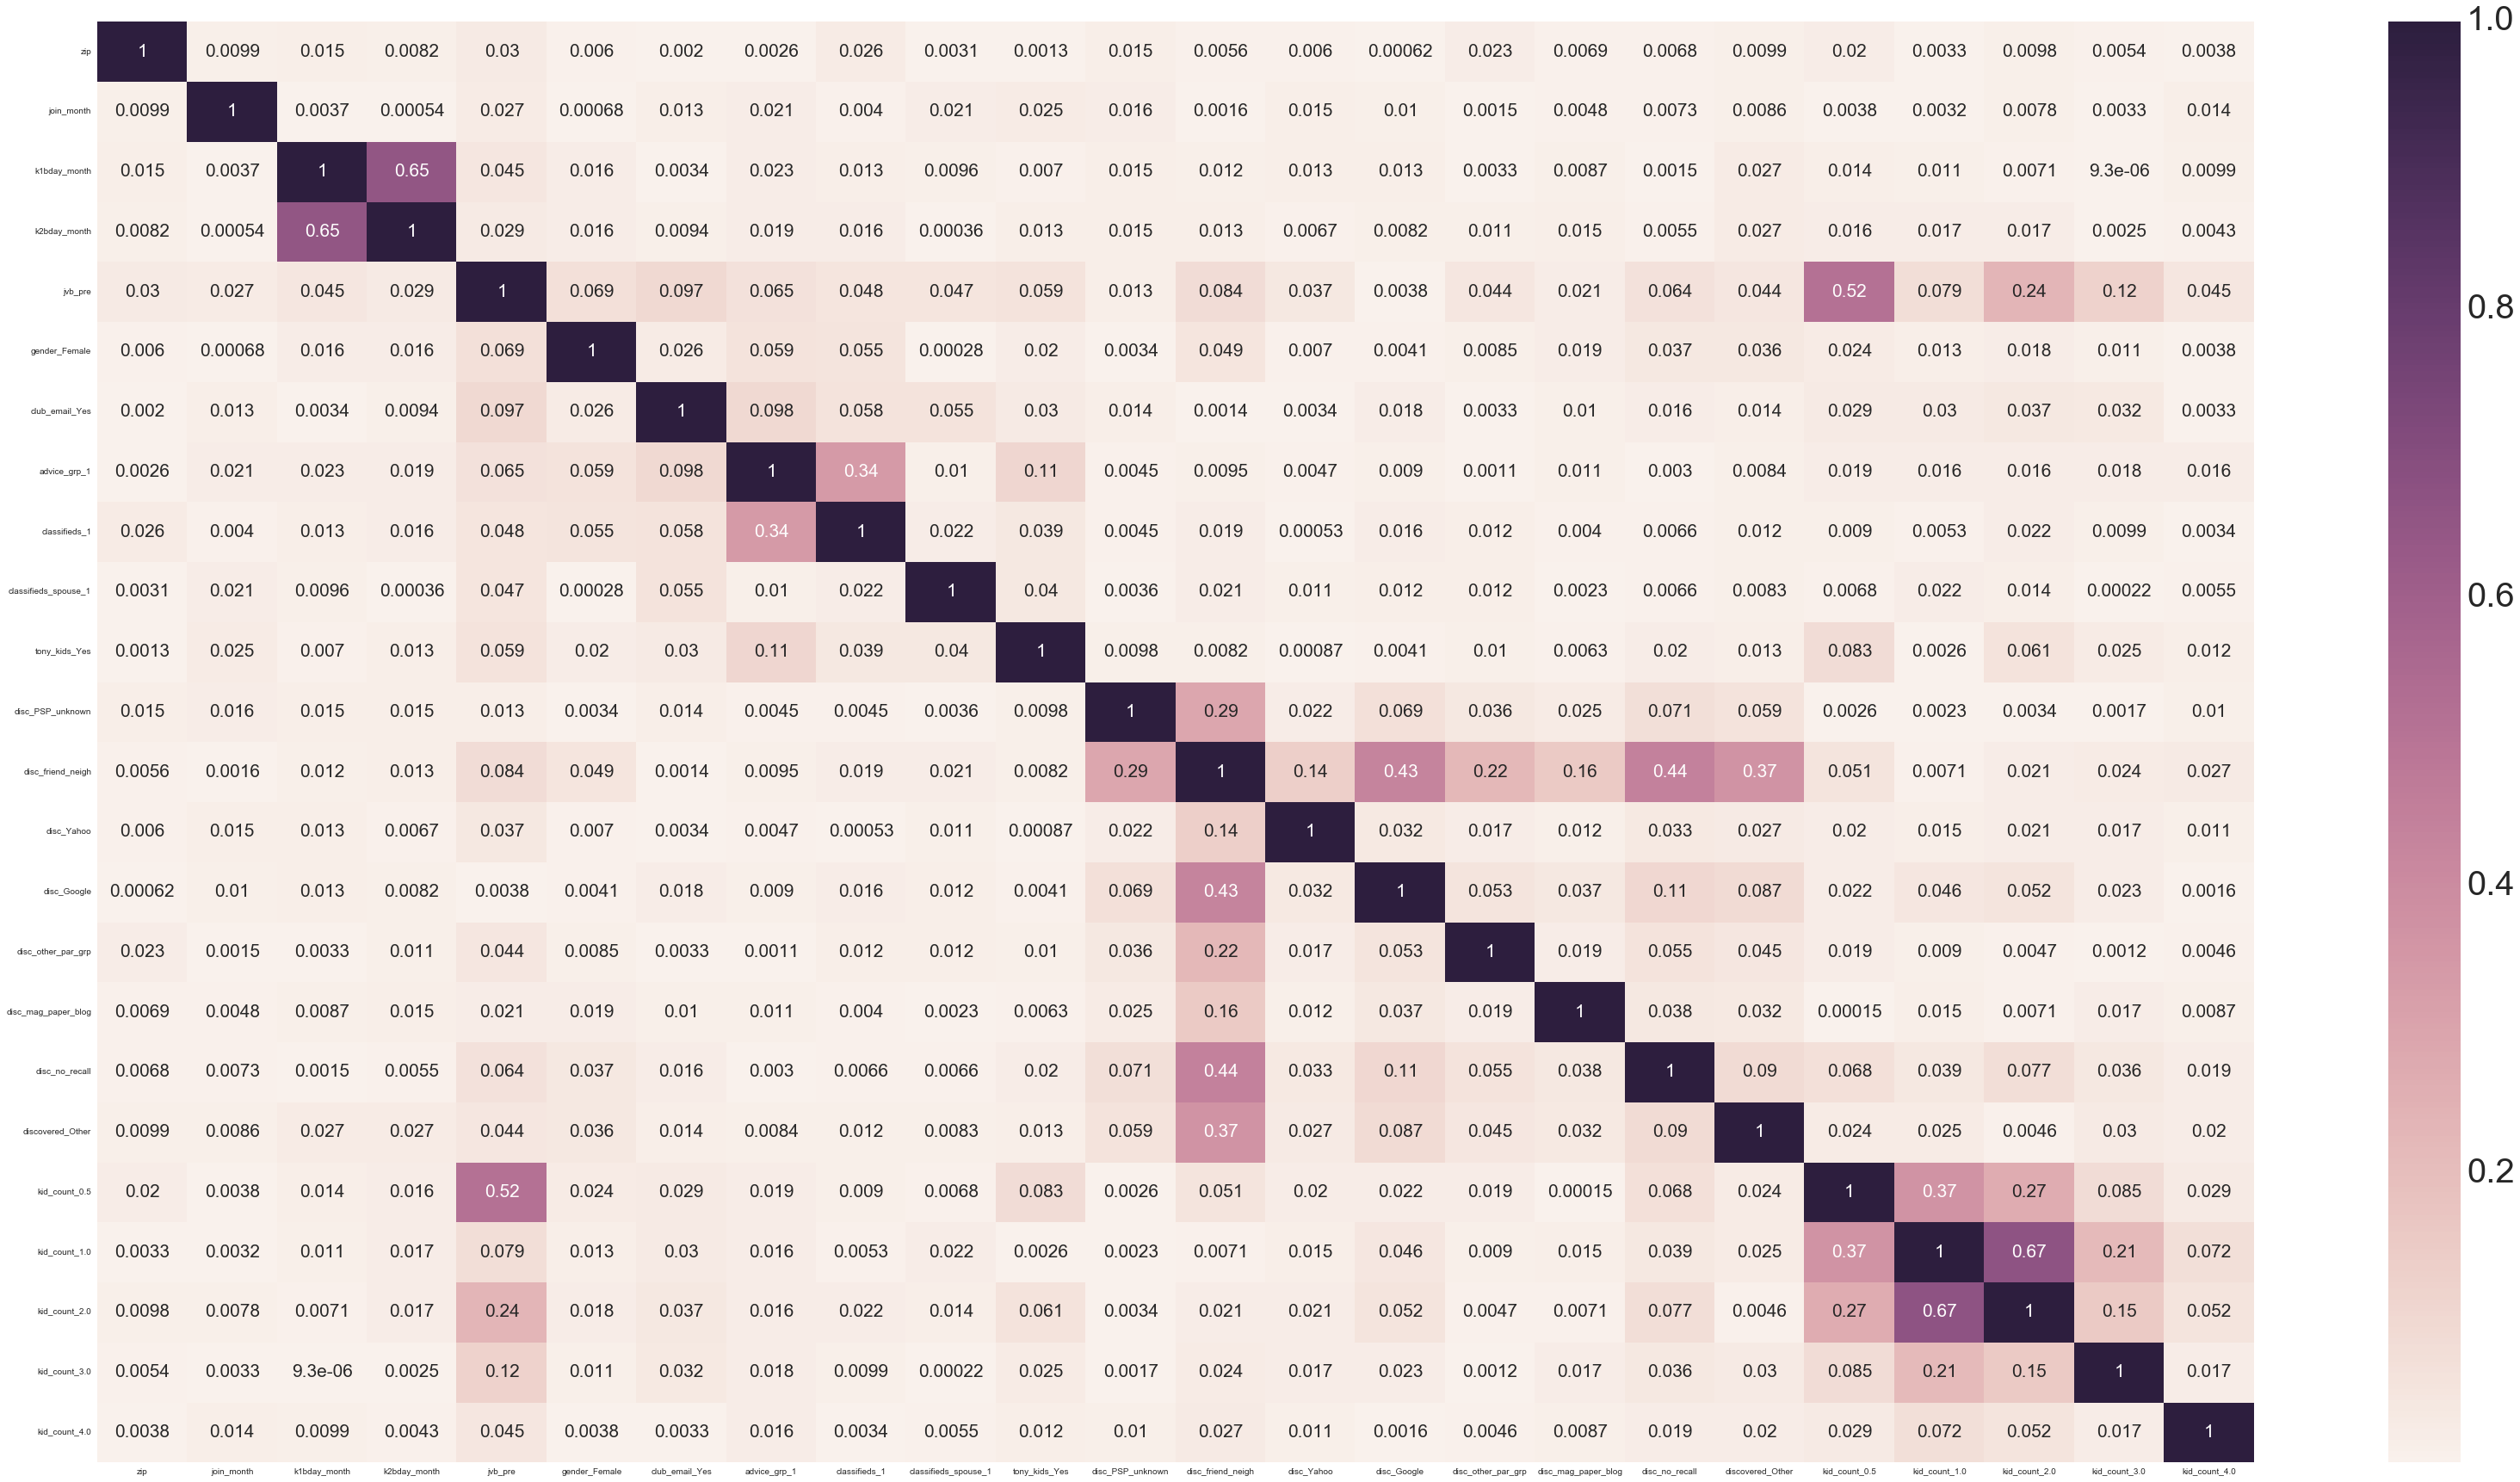

In [40]:
df_corr = abs(X.corr())

# df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_corr.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(50,30))   
sns.set(font_scale=4)
ax = sns.heatmap(df_corr, annot=True, annot_kws={"size": 21})

In [41]:
# train/test split cv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [42]:
print 'Length of X_train: ' + str(len(X_train))
print 'Length of y_train: ' + str(len(y_train))
print
print 'Length of X_test: ' + str(len(X_test))
print 'Length of y_test: ' + str(len(y_test))

Length of X_train: 9775
Length of y_train: 9775

Length of X_test: 4816
Length of y_test: 4816


In [43]:
model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

model.fit(X_test, y_test)
datatitle = examine_coefficients(model, X)
datatitle

,Coefficient,Feature
19,-2.692273,kid_count_0.5
4,-2.153315,jvb_pre
15,-0.301094,disc_other_par_grp
11,-0.206749,disc_PSP_unknown
16,-0.182638,disc_mag_paper_blog
13,-0.134541,disc_Yahoo
14,-0.129612,disc_Google
1,-0.015963,join_month
0,-0.000025,zip
2,0.005829,k1bday_month


In [44]:
# Predict the class labels for the Test set

y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [45]:
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.69344433504, all: [ 0.67029805  0.71786963  0.69216533]
mean precision: 0.715630064401, all: [ 0.68312479  0.73199153  0.73177388]
mean recall: 0.740785335347, all: [ 0.75176777  0.7717796   0.69880864]
mean roc_auc: 0.779182589683, all: [ 0.74799531  0.80736468  0.78218777]


In [46]:
# cross val scores
print cross_val_score(model, X, y, n_jobs=1, cv=5)
print cross_val_score(model, X, y, n_jobs=1, cv=5).mean()

[ 0.66906475  0.66666667  0.73646333  0.72035641  0.68289338]
0.695088907606


In [47]:
logreg_cv = LogisticRegressionCV(Cs=20, solver='liblinear', cv=3, penalty='l2', scoring='f1')
cv_model = logreg_cv.fit(X_train, y_train)

print('best C for class:')
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.Cs_,\
                                                                 logreg_cv.classes_))}
print(best_C)

best C for class:
{0: 0.0001, 1: 0.00026366508987303583}


In [48]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))

confusion = pd.DataFrame(conmat, index=['long-term', 'short-term'],
                         columns=['predicted_long','predicted_short'])

print(confusion)

            predicted_long  predicted_short
long-term             1274              853
short-term             585             2104


Very similar to training data.


In [49]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.69      0.60      0.64      2127
          1       0.71      0.78      0.75      2689

avg / total       0.70      0.70      0.70      4816



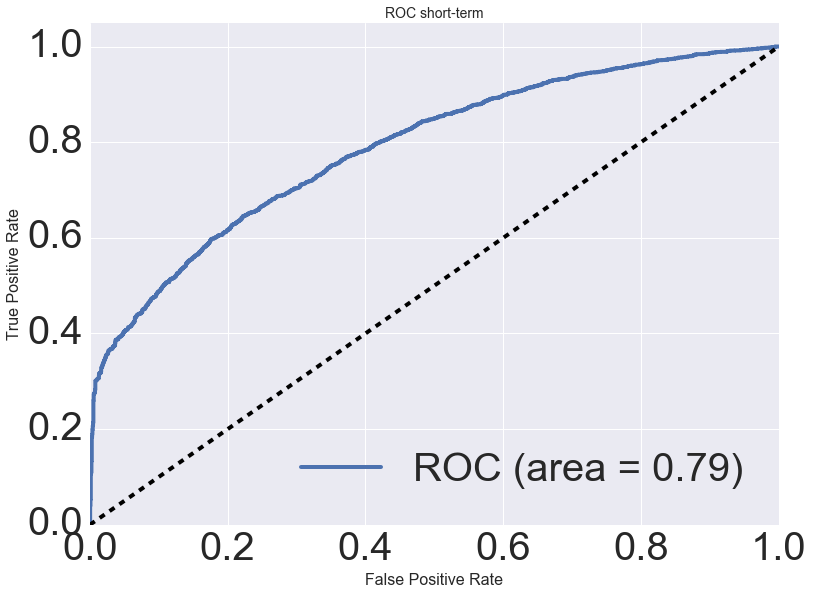

In [50]:
logreg = LogisticRegression(random_state=43)
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)


# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (fatality)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=16)
    plt.ylabel(rate2_name, fontsize=16)
    plt.title(curve_name + ' short-term', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')
    
Y_score = logreg.decision_function(X_test)
plot_roc(y_test, Y_score)

Not too shabby, but definitely room for improvement.

Running now without "joined pre"

In [51]:
# run logistic regression without joined pre-birth

model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

X2_list = ['zip','join_month','k1bday_month','k2bday_month','gender_Female','club_email_Yes',\
          'advice_grp_1','classifieds_1','classifieds_spouse_1','tony_kids_Yes',\
          'disc_PSP_unknown','disc_friend_neigh','disc_Yahoo','disc_Google','disc_other_par_grp',\
          'disc_mag_paper_blog','disc_no_recall','discovered_Other','kid_count_0.5',\
          'kid_count_1.0','kid_count_2.0','kid_count_3.0','kid_count_4.0']


X2 = dfn_r[X2_list]
y = dfn_r['long_short']

print X2.shape, y.shape


model.fit(X2, y)
datatitle = examine_coefficients(model, X2)
datatitle

(14591, 23) (14591,)


,Coefficient,Feature
18,-1.753953,kid_count_0.5
14,-0.322904,disc_other_par_grp
17,-0.234022,discovered_Other
10,-0.213875,disc_PSP_unknown
13,-0.178921,disc_Google
12,-0.152224,disc_Yahoo
9,-0.144014,tony_kids_Yes
15,-0.055302,disc_mag_paper_blog
22,-0.029104,kid_count_4.0
1,-0.021430,join_month


The strongest absolute coefficient is still expectant family with a -1.75 (down from -2.85) but the change also threw 3 children and 2 children down to +0.48 and +0.51, respectively (down from +1.24 and +1.22).

Now the next stongest absolute coefficients are:

- subscribes to club email (+0.55, down from +0.56)
- spouse subscribed to classifieds list (+0.55, down from +0.66)
- subscribes to advice group (+0.52, down from +0.61)



In [52]:
dfc_corr = abs(X2.corr())

dfc_corr = dfc_corr.applymap(lambda x: x if x >= 0.9 else '')
dfc_corr

# sending to excel for closer inspection of wide file
dfc_corr.to_csv('../../projects/psp/dfc_corr3.csv')

In [53]:
# train/test split cv

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.33)

print 'Length of X_train: ' + str(len(X2_train))
print 'Length of y_train: ' + str(len(y_train))
print
print 'Length of X_test: ' + str(len(X2_test))
print 'Length of y_test: ' + str(len(y_test))

Length of X_train: 9775
Length of y_train: 9775

Length of X_test: 4816
Length of y_test: 4816


In [54]:
model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

model.fit(X2_test, y_test)
datatitle = examine_coefficients(model, X2)
datatitle

,Coefficient,Feature
18,-1.715430,kid_count_0.5
14,-0.299006,disc_other_par_grp
10,-0.262317,disc_PSP_unknown
17,-0.191935,discovered_Other
15,-0.156538,disc_mag_paper_blog
13,-0.155016,disc_Google
12,-0.123129,disc_Yahoo
11,-0.052437,disc_friend_neigh
22,-0.036715,kid_count_4.0
1,-0.019951,join_month


In [55]:
# Predict the class labels for the Test set

y_pred = model.predict(X2_test)
print y_pred
print " "
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X2, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

[1 1 1 ..., 1 1 1]
 
mean accuracy: 0.651088132755, all: [ 0.63761562  0.6596751   0.65597368]
mean precision: 0.639917723276, all: [ 0.61888832  0.63981557  0.66104928]
mean recall: 0.849107092301, all: [ 0.89505024  0.87825763  0.7740134 ]
mean roc_auc: 0.689724933322, all: [ 0.69053307  0.70525353  0.6733882 ]


In [56]:
# cross val scores
print cross_val_score(model, X2, y, n_jobs=1, cv=5)
print cross_val_score(model, X2, y, n_jobs=1, cv=5).mean()

[ 0.64611168  0.61630695  0.69019877  0.66278273  0.64792595]
0.652665216403


In [57]:
logreg_cv = LogisticRegressionCV(Cs=20, solver='liblinear', cv=3, penalty='l2', scoring='f1')
cv_model = logreg_cv.fit(X2_train, y_train)

print('best C for class:')
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.Cs_,\
                                                                 logreg_cv.classes_))}
print(best_C)

best C for class:
{0: 0.0001, 1: 0.00026366508987303583}


In [58]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))

confusion = pd.DataFrame(conmat, index=['long-term', 'short-term'],
                         columns=['predicted_long','predicted_short'])

print(confusion)

            predicted_long  predicted_short
long-term             1008             1154
short-term             407             2247


In [59]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.71      0.47      0.56      2162
          1       0.66      0.85      0.74      2654

avg / total       0.68      0.68      0.66      4816



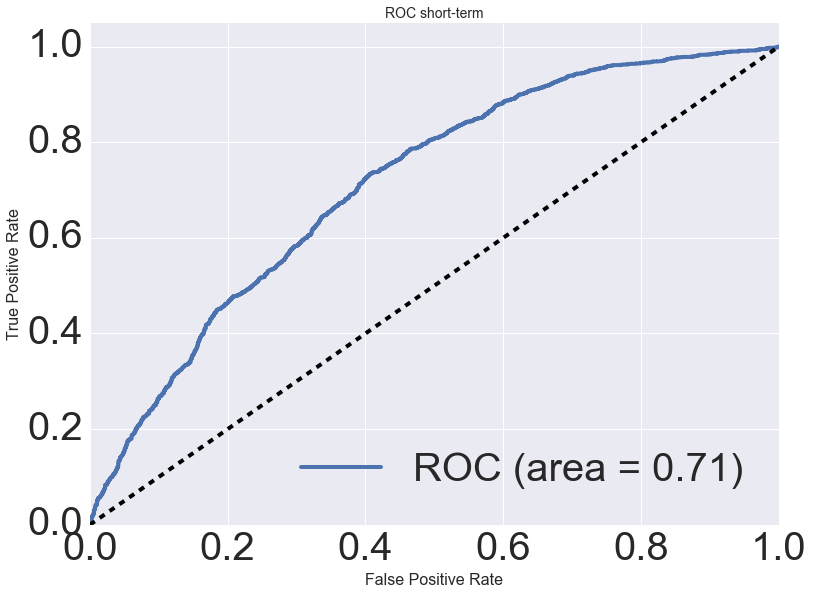

In [60]:
logreg = LogisticRegression(random_state=43)
logreg.fit(X2_train, y_train)
Y_pred = logreg.predict(X2_test)


# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (fatality)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=16)
    plt.ylabel(rate2_name, fontsize=16)
    plt.title(curve_name + ' short-term', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')
    
Y_score = logreg.decision_function(X2_test)
plot_roc(y_test, Y_score)

Not surprising that taking out a feature with a strong coefficient would hurt the model. Let's see what happens when we take out the other "duplicative" feature

In [61]:
# run logistic regression without kid_count0.5

model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

X3_list = ['zip','join_month','k1bday_month','k2bday_month','gender_Female','club_email_Yes',\
          'advice_grp_1','classifieds_1','classifieds_spouse_1','tony_kids_Yes',\
          'disc_PSP_unknown','disc_friend_neigh','disc_Yahoo','disc_Google','disc_other_par_grp',\
          'disc_mag_paper_blog','disc_no_recall','discovered_Other','jvb_pre',\
          'kid_count_1.0','kid_count_2.0','kid_count_3.0','kid_count_4.0']


X3 = dfn_r[X3_list]
y = dfn_r['long_short']

print X3.shape, y.shape


model.fit(X3, y)
datatitle = examine_coefficients(model, X3)
datatitle

(14591, 23) (14591,)


,Coefficient,Feature
18,-2.353093,jvb_pre
14,-0.582140,disc_other_par_grp
12,-0.422101,disc_Yahoo
15,-0.400761,disc_mag_paper_blog
10,-0.370145,disc_PSP_unknown
13,-0.318194,disc_Google
17,-0.239039,discovered_Other
11,-0.147086,disc_friend_neigh
1,-0.011380,join_month
3,-0.010452,k2bday_month


The strongest absolute coefficient is now, unsurprisingly, joined pre-birth with a -2.35 (down from -2.33). This change had the reverse impact on the positive coefficients for number of children and made a number of other positive correlations stronger. but the change also threw 3 children and 2 children down to +0.48 and +0.51, respectively (down from +1.24 and +1.22).

- 2 kids (+3.92, up from +1.22)
- 3 kids (+3.85, up from +1.24)
- 1 kid (+3.25, up from +0.61)
- spouse subscribed to classifieds list (+1.05, up from +0.66)


In [62]:
# train/test split cv

X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.33)

print 'Length of X_train: ' + str(len(X3_train))
print 'Length of y_train: ' + str(len(y_train))
print
print 'Length of X_test: ' + str(len(X3_test))
print 'Length of y_test: ' + str(len(y_test))

Length of X_train: 9775
Length of y_train: 9775

Length of X_test: 4816
Length of y_test: 4816


In [63]:
model = linear_model.LogisticRegression(penalty = 'l2', C = 10.0) 

model.fit(X3_test, y_test)
datatitle = examine_coefficients(model, X3)
datatitle

,Coefficient,Feature
18,-1.761805,jvb_pre
14,-0.574372,disc_other_par_grp
10,-0.403179,disc_PSP_unknown
13,-0.300436,disc_Google
12,-0.158726,disc_Yahoo
15,-0.079084,disc_mag_paper_blog
17,-0.055394,discovered_Other
11,-0.054800,disc_friend_neigh
22,-0.044484,kid_count_4.0
1,-0.011364,join_month


In [64]:
# Predict the class labels for the Test set

y_pred = model.predict(X3_test)
print y_pred
print " "
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X3, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

[0 1 1 ..., 0 1 0]
 
mean accuracy: 0.701118252309, all: [ 0.69290853  0.71663582  0.69381041]
mean precision: 0.722489426132, all: [ 0.7003695   0.73044397  0.7366548 ]
mean recall: 0.747111447218, all: [ 0.77595832  0.7717796   0.69359643]
mean roc_auc: 0.787959031778, all: [ 0.76718081  0.81306967  0.78362661]


In [65]:
# cross val scores
print cross_val_score(model, X3, y, n_jobs=1, cv=5)
print cross_val_score(model, X3, y, n_jobs=1, cv=5).mean()

[ 0.68859198  0.66289825  0.74571624  0.70801919  0.6774083 ]
0.696526793561


In [66]:
logreg_cv = LogisticRegressionCV(Cs=20, solver='liblinear', cv=3, penalty='l2', scoring='f1')
cv_model = logreg_cv.fit(X3_train, y_train)

print('best C for class:')
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.Cs_,\
                                                                 logreg_cv.classes_))}
print(best_C)

best C for class:
{0: 0.0001, 1: 0.00026366508987303583}


In [67]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))

confusion = pd.DataFrame(conmat, index=['long-term', 'short-term'],
                         columns=['predicted_long','predicted_short'])

print(confusion)

            predicted_long  predicted_short
long-term             1545              648
short-term             784             1839


In [68]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.66      0.70      0.68      2193
          1       0.74      0.70      0.72      2623

avg / total       0.70      0.70      0.70      4816



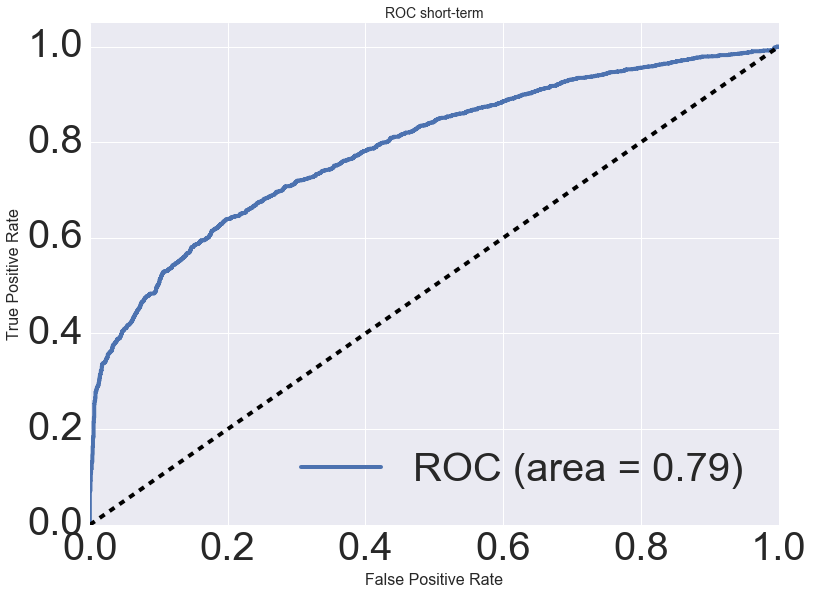

In [69]:
logreg = LogisticRegression(random_state=43)
logreg.fit(X3_train, y_train)
Y_pred = logreg.predict(X3_test)


# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (fatality)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=16)
    plt.ylabel(rate2_name, fontsize=16)
    plt.title(curve_name + ' short-term', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')
    
Y_score = logreg.decision_function(X3_test)
plot_roc(y_test, Y_score)

Taking out the feature that was self-reported as not yet having a child actually resulted in a slightly improved model so I will be using that for the remaining functions

In [70]:
logreg = LogisticRegression(solver='liblinear')
C_vals = np.logspace(-5,1,50)
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=5)
gs.fit(X3, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...    2.44205e+00,   3.23746e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [71]:
gs.best_params_

{'C': 0.082864277285468427, 'penalty': 'l1'}

In [72]:
logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X3_train, y_train)


cv_pred = cv_model.predict(X3_test)

cm = confusion_matrix(y_test, cv_pred, labels=logreg.classes_)

cm = pd.DataFrame(cm, columns=logreg.classes_, index=logreg.classes_)

cm

,0,1
0,1386,807
1,631,1992


In [73]:
conmat2 = np.array(confusion_matrix(y_test, cv_pred, labels=[0,1]))

confusion2 = pd.DataFrame(conmat2, index=['long-term', 'short-term'],
                         columns=['predicted_long','predicted_short'])

print(confusion2)

            predicted_long  predicted_short
long-term             1386              807
short-term             631             1992


GridsearchCV actually hurt the model slightly.

The model now predicts long-term membership correctly 65% of the time (rather than 69% originally).


In [74]:
y.value_counts()/y.count()

1    0.552327
0    0.447673
Name: long_short, dtype: float64

In [75]:
dt = DecisionTreeClassifier()

In [76]:
def do_cross_val(model):
    scores = cross_val_score(model, X3, y, cv=5, n_jobs= -1)
    return scores.mean(), scores.std()

do_cross_val(dt)

(0.63717825423032448, 0.023832752031407865)

In [77]:
bdt = BaggingClassifier(DecisionTreeClassifier())

In [78]:
do_cross_val(bdt)

(0.66116616169233144, 0.031504114573596004)

In [79]:
pipedt = make_pipeline(RobustScaler(), dt)

pipebdt = make_pipeline(RobustScaler(),bdt)

In [80]:
do_cross_val(pipedt)

(0.63710969062149303, 0.023989884705766493)

In [81]:
do_cross_val(pipebdt)

(0.66061774698587539, 0.030562796089342082)

These are okay, but not as good as logreg.

Going to GridSearchCV on them and see if that helps

In [82]:
params = {'max_depth': [3,5,10,20],
          'max_features': [None, 'auto'],
         'min_samples_leaf': [1,3,5,7,10],
         'min_samples_split': [2,5,7]}

gsdt = GridSearchCV(dt, params, n_jobs= -1, cv=5)

In [83]:
gsdt.fit(X3,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'auto'], 'min_samples_split': [2, 5, 7], 'max_depth': [3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [84]:
gsdt.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [85]:
gsdt.best_score_

0.69419505174422591

I'm thinking we're not going to break past that 70% CVS we saw for logreg

In [86]:
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=43)

In [87]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, X3, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.649 ± 0.012


In [88]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)

In [89]:
bagging.fit(X3,y)


BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [90]:
# bagging classifier
num_folds = 10
num_instances = len(X)
seed = 43
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_validation.cross_val_score(model, X3, y, cv=kfold)
print(results.mean())

0.677677288817


In [91]:
# Random Forest Classification

max_features = 3
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_validation.cross_val_score(model, X3, y, cv=kfold)
print(results.mean())

0.680349272818


In [92]:
# Extra Trees Classification

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_validation.cross_val_score(model, X3, y, cv=kfold)
print(results.mean())

0.665065582544


In [93]:
# AdaBoost Classification
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = cross_validation.cross_val_score(model, X3, y, cv=kfold)
print(results.mean())

0.707693578826


In [94]:
# Gradient Boosting Classification

model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_validation.cross_val_score(model, X3, y, cv=kfold)
print(results.mean())

0.710093561926


Ensemble methods really haven't worked for me for this model. 

No reason to bother with feature importances on the ensembles.

Final thing that I'm going to do with this project is clustering on PCA (PCA is just because there are so many features).

In [95]:
# Declaring my features and separating out the member numbers

x = dfn_r.ix[:,1:24].values
y = dfn_r.ix[:,0].values


# scaling the feature values so that PCA may work
xStand = pd.DataFrame(StandardScaler().fit_transform(x), columns=dfn_r.columns[1:24])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

In [96]:
# fit standardized data for PCA

pca = PCA(n_components=3)
X = pca.fit_transform(xStand)

In [97]:
# a bunch of pca eigenstuffs

covMat = np.cov(X.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0]);

1.90349786857
1.69389648605
1.64771956807


In [98]:
# show what variance is explained by each CP

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  36.2908775   68.5856286  100.       ]


In [99]:
# Let's see the PCs and make a DF out of them for future use

PCAdf = pd.DataFrame(X, columns=['PC1','PC2','PC3'])
j = PCAdf.PC1
k = PCAdf.PC2
l = PCAdf.PC3

PCAdf.head()

,PC1,PC2,PC3
0,-1.232856,-0.161963,2.923739
1,-2.495801,-1.179823,-1.367116
2,-0.245147,-1.548512,0.437119
3,-0.249792,-1.438352,1.148710
4,0.742938,0.913889,-0.500593


In [100]:
# Let's see how closely related each PC is to the original features

PCPieces = abs(pd.DataFrame(pca.components_, columns = dfn_r.columns[1:24], index = ['PC1', 'PC2', 'PC3']))
PCPieces.T.sort_values('PC1', ascending = False).head(30)

,PC1,PC2,PC3
jvb_pre,0.472948,0.086425,0.016596
disc_friend_neigh,0.423363,0.291508,0.174601
kid_count_0.5,0.415241,0.226973,0.008880
kid_count_2.0,0.359720,0.528949,0.227902
disc_no_recall,0.274672,0.052500,0.137693
k1bday_month,0.184901,0.147009,0.641013
k2bday_month,0.184140,0.153804,0.638178
discovered_Other,0.182672,0.075169,0.017984
gender_Female,0.120291,0.012778,0.010723
club_email_Yes,0.114829,0.045769,0.004690


In [101]:
# more eigenstuffs

eigen_pairs = [[eigenValues[i], eigenVectors[:,i]] for i in range(len(eigenValues))]
eigen_pairs.sort(reverse=True)

weight_2d_projection = np.hstack((eigen_pairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigen_pairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection;

Weight data 2d PCA projection matrix:
[[ -1.00000000e+00  -1.10923403e-14]
 [  1.10923403e-14  -1.00000000e+00]
 [  8.86599867e-15  -5.64339333e-14]]


In [102]:
# trace1 = go.Scatter3d(
#     x=j,
#     y=k,
#     z=l,
#     mode='markers',
#     marker=dict(
#         size=5,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.1
#         ),
#         opacity=0.05
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='psp_pca_3dscat')

In [103]:
# that's a little tight. Maybe we should plot out each pair.

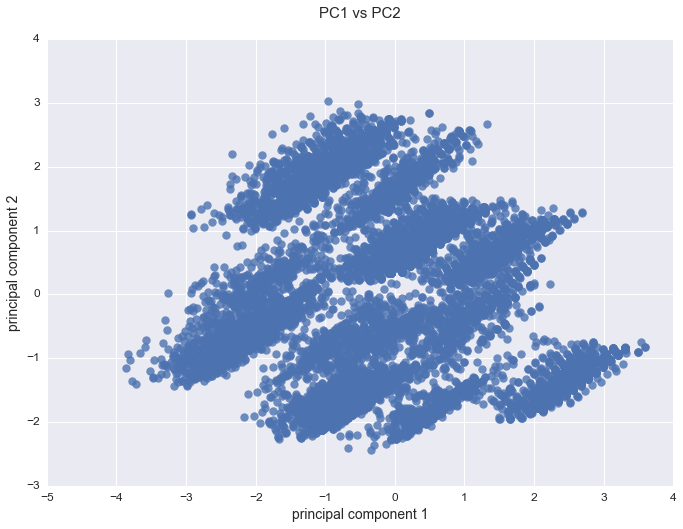

In [ ]:
# PC1 vs PC2

fig = plt.figure(figsize=(10,8))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=14)
ax.set_ylabel('principal component 2', fontsize=14)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=15
            )

plt.show()

You can sort of see something going on in there, too.

Let's move on to clustering

In [ ]:
db = DBSCAN(eps =10, min_samples=3)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

In [ ]:
fig = plt.figure(figsize=(10,8))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5)

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

plt.title('Number of clusters: %d' % n_clusters_, fontsize=25);

DB-SCAN only sees 2 clusters. Feh.

Let's give KMeans a chance


In [ ]:
# test for best # of k

k_list = [2, 3, 4,5,6]

for k in k_list:
    kmean = KMeans(n_clusters=k)
    kmean.fit(dfn_r)
    random_state = 43
    print k, silhouette_score(dfn_r, kmean.labels_), kmean.inertia_
   

In [ ]:
# 2 clusters have a much stronger inertia, but I think having 3 clusters would be more 
# useful so I'm going with those.

chosen_k = 3

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf)
    
label = pd.Series(kmean.labels_, name = 'label')

kmean_df = pd.concat([PCAdf,label], axis = 1)
kmean_df.head()

In [ ]:
kmean_df.head()

In [ ]:
# visualizing k-means with 3 cluster

centroid = pd.DataFrame(kmean.cluster_centers_, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = centroid['PC1'] , ys = centroid['PC2'], zs = centroid['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=3', fontsize = 20)

plt.show()

So pretty!

Let's see how many members are in each of these clusters

In [ ]:
kmean_df['label'].value_counts()

In [ ]:
# Make a dataframe of the members by cluster label

kml = pd.DataFrame(kmean.labels_)

kml.info()

In [ ]:
# and now a new dataframe that includes the member data with the cluster label data

dfn_r.reset_index(drop=True, inplace=True)
kml.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfn_r,kml], axis = 1)

print len(dfc)
dfc.head()

In [ ]:
# a little head cleaning

dfc.rename(columns={0:'cluster'}, inplace=True)

# give the clusters nicer names

def new_name(x):
    if x == 0:
        return "Cluster A"
    elif x == 1:
        return "Cluster B"
    else:
        return "Cluster C"
    
dfc['cluster_name'] = dfc['cluster'].apply(new_name);

dfc.pop('cluster')

print len(dfc)
dfc.head()

In [ ]:
# Now we're ready to see each cluster individually

# isolating Cluster A
cluster0 = pd.DataFrame(dfc.loc[dfc['cluster_name'] == 'Cluster A'])

# isolating Cluster B
cluster1 = pd.DataFrame(dfc.loc[dfc['cluster_name'] == 'Cluster B'])

# isolating Cluster C
cluster2 = pd.DataFrame(dfc.loc[dfc['cluster_name'] == 'Cluster C'])



In [ ]:
dfn_r.info()

In [ ]:
# Now I'll group the clusters together so I can see what they have in common

gb = dfc.groupby(['cluster_name'])[['long_short','join_month','k1bday_month','k2bday_month','jvb_pre','gender_Female',\
                                     'club_email_Yes','advice_grp_1','classifieds_1','classifieds_spouse_1',\
                                     'tony_kids_Yes','disc_PSP_unknown','disc_friend_neigh','disc_Yahoo',\
                                     'disc_Google','disc_other_par_grp','disc_mag_paper_blog','disc_no_recall',\
                                     'discovered_Other','kid_count_1.0','kid_count_2.0','kid_count_3.0',\
                                     'kid_count_4.0']].mean()

In [ ]:
# transforming groupby into a dataframe

gbdf = pd.DataFrame(gb)

gbdf.reset_index(drop=False, inplace=True)
gbdf.head()

In [ ]:
# lots to look through but I'm only going to show charts that have difference / meaning.

fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.long_short)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title('Long Term Member', fontsize=15)
    
plt.show()


In [ ]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.k1bday_month)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("First Child's Birthday Month", fontsize=15)
    
plt.show()

In [ ]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.jvb_pre)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("Joined While Expecting", fontsize=15)
    
plt.show()

In [ ]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.disc_friend_neigh)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("Discovered PPP through Member Who is a Friend/Neighbor", fontsize=15)
    
plt.show()

In [ ]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.disc_Google)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("Discovered PPP through Google", fontsize=15)
    
plt.show()

In [ ]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.disc_other_par_grp)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("Discovered PPP through Other Parenting Group", fontsize=15)
    
plt.show()

In [ ]:
# interesting that the decimal point in the kid counts hasn't been an issue until now

gbdf.rename (columns={"kid_count_1.0":"kid_count_1"}, inplace=True)
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.kid_count_1)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("1 Child", fontsize=15)
    
plt.show()

In [ ]:
gbdf.rename (columns={"kid_count_2.0":"kid_count_2"}, inplace=True)
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.kid_count_2)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("2 Children", fontsize=15)
    
plt.show()

## Clustering Take-aways:


#### Cluster A:
* Cluster A members are more likely to be long-term members than either of the other clusters, which are fairly even split between long and short.
* None of these members had 1 child, almost all had 2


#### Cluster B: 
* I'm not sure how this could be actionable, but it's interesting that children in this cluster were born later than children in Clusters A and C
* These members were far less likely to join the group than members of the other two clusters.
* Members in this cluster were the most likely to have found PPP through a friend or neighbor who is also a member of the group. 
* The other clusters were much more likely to have found PPP through another parenting group than the other clusters.
* very few of these members had more than 1 child.


#### Cluster C:
* These members were much more likely to have found PPP through Google than the other clusters were
* Almost all of these members were single-child families.


In [ ]:
gbdf.rename (columns={"kid_count_3.0":"kid_count_3"}, inplace=True)
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.kid_count_3)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("3 Children", fontsize=15)
    
plt.show()

In [ ]:
gbdf.rename (columns={"kid_count_4.0":"kid_count_4"}, inplace=True)
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.kid_count_4)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
plt.yticks(fontsize=12)
plt.title("4+ Children", fontsize=15)
    
plt.show()